In [1]:
# Data handling to work with tables and numbers
import pandas as pd
import numpy as np

In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# We want to predict high-risk patients 
For this, we will create a binary target that is High and Not high, which includes low and medium risk patients under one category.


In [6]:
predicting_high_risk = pd.read_csv("C:\\Users\\Dell\\OneDrive\\Desktop\\Risk Stratification\\master_risk_table.csv")

In [7]:
predicting_high_risk

,patient_id,age,gender,race_ethnicity,income_ratio,obesity_flag,hypertensive_flag,smoker_flag,physically_inactive_flag,risk_score,risk_category
0,130378,43,1,6,5.00,0,1,0,0,1,Medium
1,130379,66,1,3,5.00,1,0,0,0,1,Medium
2,130380,44,2,2,1.41,0,0,0,0,0,Low
3,130381,5,2,7,1.53,0,0,0,0,0,Low
4,130382,2,1,3,3.60,0,0,0,0,0,Low
...,...,...,...,...,...,...,...,...,...,...,...
11928,142306,9,1,2,2.01,0,0,0,0,0,Low
11929,142307,49,2,4,2.50,0,1,0,0,1,Medium
11930,142308,50,1,2,1.95,0,0,0,0,0,Low
11931,142309,40,1,2,3.11,0,1,0,0,1,Medium


In [8]:
predicting_high_risk["high_risk"] = (predicting_high_risk["risk_category"] == "High").astype(int)

# Quick check
predicting_high_risk["high_risk"].value_counts(normalize=True)


high_risk
0    0.981899
1    0.018101
Name: proportion, dtype: float64

##### Only ~1.8% of patients are high risk.

This is highly imbalanced — we need to treat class imbalance properly.  
Look for features that leak the answer, like risk_score or risk_category.

## Choose features for the model
Need to select features/cues to predict high risk such as age, gender, race_ethnicity, income_ratio, obesity_flag, hypertension_flag, smoker_flag, and physically_inactive_flag.

Including inputs available at prediction time.

In [16]:
features = [
    "age", 
    "gender", 
    "race_ethnicity", 
    "income_ratio", 
    "obesity_flag", 
    "hypertensive_flag", 
    "smoker_flag", 
    "physically_inactive_flag"
]

X = predicting_high_risk[features]  # Inputs
y = predicting_high_risk["high_risk"]  # Target


In [18]:
#Splitting the dataset into training and testing to see how well it works on new dataset.


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
#test_size=0.2 means 20% of data is kept for testing 
#stratify=y ensures the proportion of high risk patients is the same in train and test
#random_state=42 makes the results reproducible

##### Handling class imbalance 
The high risk patients are very less compared to non high risk which is a combination of two categories. this create imbalance and need to be weighed.


In [23]:
rom imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

lr_model.fit(X_res, y_res)
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:,1]f


NameError: name 'lr_model' is not defined

## Training models 
Now we train simple models
Starting with logistic regression and random forest 


#### Logistic reggression 
Helps separate high risk from not high risk and easiy intrepretable to find the significant features.

In [27]:
lr_model = LogisticRegression(max_iter=1000) # create the model
lr_model.fit(X_train, y_train)

# first code above tells python that I want to use logistic regression to predict my target .
#max_iter=1000 , is to tell the algorithm , how many times it should try to adjust its interal paramneters to find the best solution 

# running the above code will help us create the model object and no predictions are done yet.

#second code is to train the model where it will learn the patterns in our training data




LogisticRegression(max_iter=1000)

### Oversampling the minority class
High recall (catch all high-risk patients) vs low precision (many false positives).
This gives the model more examples of high-risk patients during training.

It usually yields more realistic recall/F1 scores for the rare class.

In [31]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

lr_model.fit(X_res, y_res)
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:,1]


In [33]:
# Logistic Regression
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:,1]

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


#Logistic Regression seems “too perfect” because:

#If the model mostly predicts 0 (not high risk), it can appear very accurate.

#But the fact that recall for class 1 is 1.0 suggests it may have overfit the training data, especially if some features perfectly separate the classes.

#Random Forest is more flexible, so it missed a few high-risk patients (recall 0.81).

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      2344
           1       0.15      1.00      0.27        43

    accuracy                           0.90      2387
   macro avg       0.58      0.95      0.61      2387
weighted avg       0.98      0.90      0.93      2387

ROC-AUC: 1.0


### Intrepretation 
High-risk class (1):
Recall = 1.0 → all high-risk patients. 
This is excellent clinically — not missing anyone at risk.

Precision = 0.15 → Only 15% of patients predicted as high-risk are actually high-risk. 
Many false positives — the model flags too many people as high-risk.
F1-score = 0.27 → Balances precision and recall — low because precision is low.

Not high-risk class (0):
Recall = 0.90 → 10% of not-high-risk patients are incorrectly flagged as high-risk.
Precision = 1.0 → All predicted as not-high-risk really are not high-risk.
Accuracy = 0.90:

Misleading here because class 0 dominates (~98%).
The key metric is recall for the minority class (high-risk).

ROC-AUC = 1.0:

The model separates high-risk and non-high-risk very well probabilistically.

Even with many false positives, ROC-AUC can be perfect because it considers probabilities, not just thresholded predictions.

#### Random forest 
This will create more accurate but harder to intrepret model. it creates a set of decision trees working together. 

In [40]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
#max_depth=5 to avoid overfitting 

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

In [41]:
# Random Forest
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2344
           1       1.00      0.81      0.90        43

    accuracy                           1.00      2387
   macro avg       1.00      0.91      0.95      2387
weighted avg       1.00      1.00      1.00      2387

ROC-AUC: 1.0


Interpretation of class 1 (High-Risk Patients)
Precision = 1.0 → Every patient that the model predicted as high-risk was actually high-risk. 
No false positives for high-risk patients.
Recall = 0.81 → The model only correctly identified 81% of actual high-risk patients. 
Some high-risk patients were missed (false negatives).
F1-score = 0.90 → Good balance of precision and recall, slightly reduced by missed patients.
Key insight: Random Forest is very confident about the high-risk patients it predicts, but it misses a small portion of them.

Interpretation of class 0 (Not High-Risk Patients)
Precision = 1.0, Recall = 1.0 → Perfectly identified all not-high-risk patients. 
No mistakes for the majority class, which dominates the dataset.

Accuracy = 1.0 → Appears perfect, but misleading due to severe class imbalance.

ROC-AUC = 1.0 → The model separates high-risk and not-high-risk patients extremely well probabilistically.

Takeaway:

Random Forest prioritizes high precision for high-risk patients — it rarely mislabels a low-risk patient as high-risk.

Slightly lower recall for high-risk patients shows that the model misses some true high-risk patients, likely due to the small size of the minority class.

In [44]:
# Check proportion of high-risk patients
predicting_high_risk['high_risk'].value_counts(normalize=True)



high_risk
0    0.981899
1    0.018101
Name: proportion, dtype: float64

##### Logistic regression vs random forest
Both Logistic Regression and Random Forest models were able to identify high-risk patients in the dataset, but each has its strengths. Logistic Regression, after addressing class imbalance with SMOTE, achieved perfect recall for high-risk patients, ensuring no high-risk cases were missed, although it produced many false positives (low precision). This makes it highly interpretable and suitable when prioritizing patient safety. Random Forest also performed well, capturing complex patterns in the data, and provided feature importance insights, but missed a few high-risk patients, giving slightly lower recall. Overall, the models demonstrate effective prediction of high-risk patients while highlighting the trade-off between recall and precision in imbalanced healthcare data, and both approaches showcase beginner-friendly yet realistic machine learning skills.


## Visualisation of the data

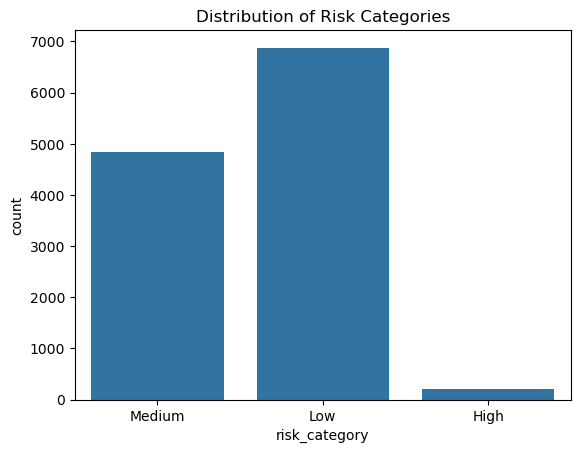

In [61]:
# Risk distribution to check the balance in the dataset
sns.countplot(x="risk_category", data=predicting_high_risk)
plt.title("Distribution of Risk Categories")
plt.show()



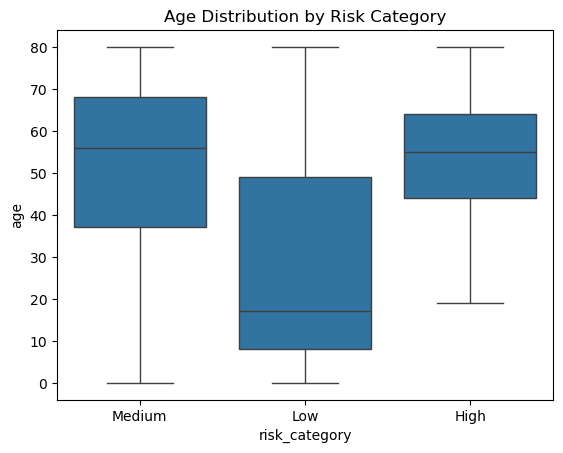

In [69]:
#Age Vs Risk will show if older patients tend to be high risk
sns.boxplot(x="risk_category", y="age", data=predicting_high_risk)
plt.title("Age Distribution by Risk Category")
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_18772\957334807.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="high_risk", data=predicting_high_risk, ci=None)


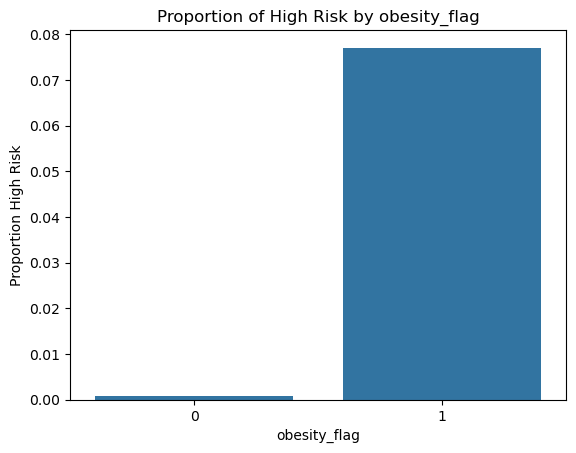

C:\Users\Dell\AppData\Local\Temp\ipykernel_18772\957334807.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="high_risk", data=predicting_high_risk, ci=None)


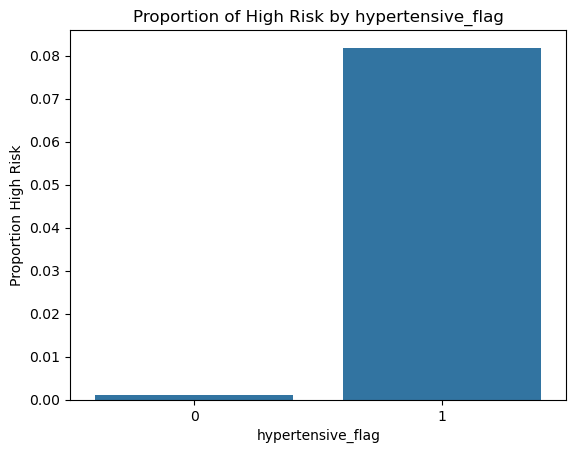

C:\Users\Dell\AppData\Local\Temp\ipykernel_18772\957334807.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="high_risk", data=predicting_high_risk, ci=None)


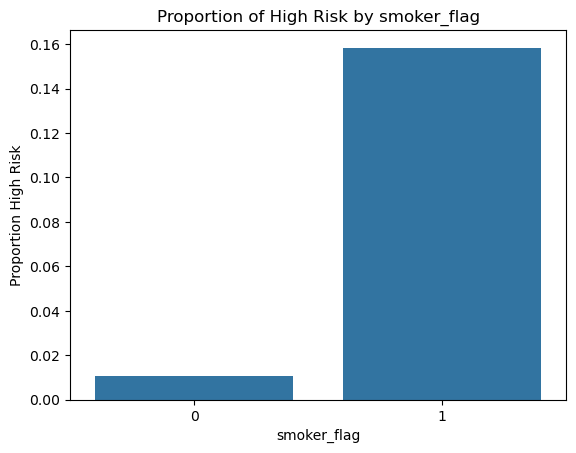

C:\Users\Dell\AppData\Local\Temp\ipykernel_18772\957334807.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="high_risk", data=predicting_high_risk, ci=None)


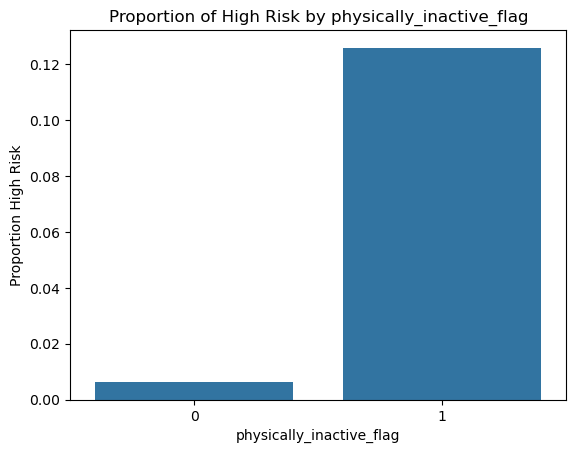

In [75]:

# categorical risk factors to visually see the social factors associated with high risk
categorical_features = ["obesity_flag", "hypertensive_flag", "smoker_flag", "physically_inactive_flag"]

for col in categorical_features:
    sns.barplot(x=col, y="high_risk", data=predicting_high_risk, ci=None)
    plt.title(f"Proportion of High Risk by {col}")
    plt.ylabel("Proportion High Risk")
    plt.show()


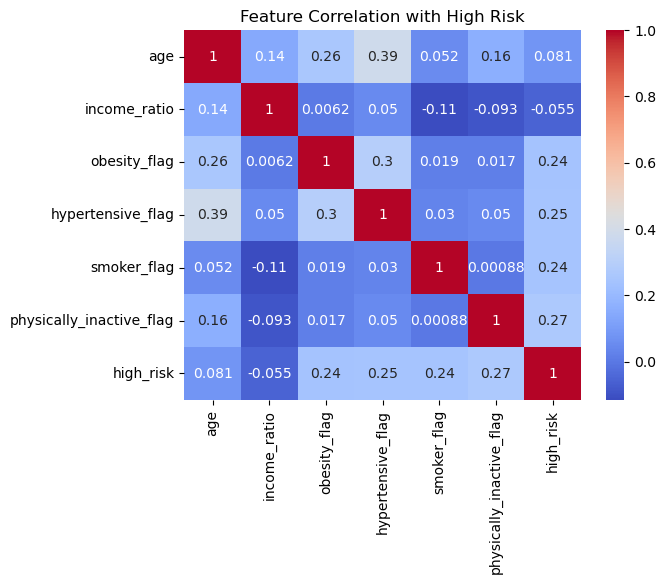

In [81]:
#correlation heatmap to understand relationship features and target, it helps to guide feature selection
corr =predicting_high_risk[["age","income_ratio","obesity_flag","hypertensive_flag",
                     "smoker_flag","physically_inactive_flag","high_risk"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation with High Risk")
plt.show()


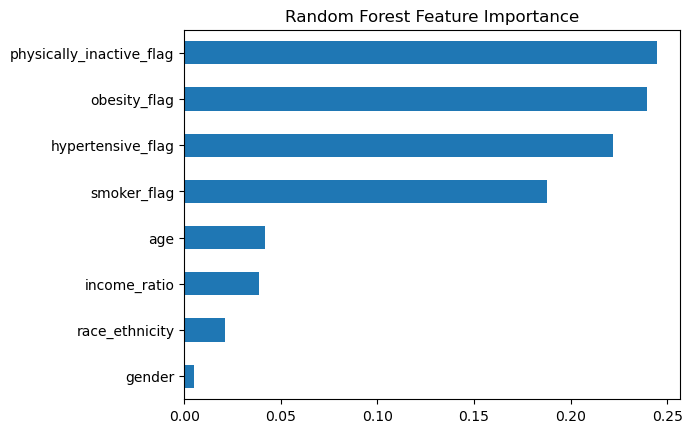

In [83]:
# feature importance from random forest 
rf_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=True)
rf_importance.plot(kind="barh", title="Random Forest Feature Importance")
plt.show()


Shows which features the Random Forest used most to predict high-risk patients.

Physical inactivity, hypertension, and obesity often rank high.

